In [3]:
import json
import re

In [4]:
# Load dataset json
data = []
with open('data/train.json', 'r') as file:
    for line in file:
        if line.strip():  # Skip empty lines
            data.append(json.loads(line))

# Now data is a list of dictionaries, each containing one record
print(f"Loaded {len(data)} records")

Loaded 498795 records


## ChatGPT Generated Code
Takes imported dictionary, converts equations to reverse polish notation strings, and store the reverse polish notation strings in a seperate dictionary column

In [5]:
# Define the functions we expect to see.
FUNCTIONS = {"sin", "cos", "exp", "log"}

# Define operators with their precedence and associativity.
OPERATORS = {
    '+': {'precedence': 2, 'associativity': 'left'},
    '-': {'precedence': 2, 'associativity': 'left'},
    '*': {'precedence': 3, 'associativity': 'left'},
    '/': {'precedence': 3, 'associativity': 'left'},
    '**': {'precedence': 4, 'associativity': 'right'},
}

def tokenize(expression):
    """
    Tokenizes the expression into numbers, variables, functions, operators, and parentheses.
    Supports multi-character operators like "**".
    """
    token_pattern = r'\d+\.\d+|\d+|[A-Za-z_][A-Za-z0-9_]*|\*\*|[+\-*/()]'
    tokens = re.findall(token_pattern, expression)
    return tokens

def infix_to_rpn(expression):
    """
    Converts an infix expression string to its Reverse Polish Notation (RPN) equivalent.
    """
    output = []
    stack = []
    tokens = tokenize(expression)
    
    for token in tokens:
        # If the token is a number or variable/identifier.
        if re.match(r'\d+(\.\d+)?$', token) or re.match(r'[A-Za-z_][A-Za-z0-9_]*$', token):
            # If the token is a recognized function, push it onto the stack.
            if token in FUNCTIONS:
                stack.append(token)
            else:
                output.append(token)
        elif token == ',':
            # Function argument separator: pop until '('.
            while stack and stack[-1] != '(':
                output.append(stack.pop())
        elif token in OPERATORS:
            # Operator: pop higher precedence operators from the stack.
            while (stack and stack[-1] in OPERATORS and
                   ((OPERATORS[token]['associativity'] == 'left' and OPERATORS[token]['precedence'] <= OPERATORS[stack[-1]]['precedence']) or
                    (OPERATORS[token]['associativity'] == 'right' and OPERATORS[token]['precedence'] < OPERATORS[stack[-1]]['precedence']))):
                output.append(stack.pop())
            stack.append(token)
        elif token == '(':
            stack.append(token)
        elif token == ')':
            # Pop until the matching '('.
            while stack and stack[-1] != '(':
                output.append(stack.pop())
            if stack and stack[-1] == '(':
                stack.pop()  # Remove the '('
            # If a function is on top of the stack, pop it to output.
            if stack and stack[-1] in FUNCTIONS:
                output.append(stack.pop())
    
    # Pop any remaining operators from the stack.
    while stack:
        output.append(stack.pop())
        
    return " ".join(output)

# Process each record: convert the single-string "Skeleton" equation to RPN.
for record in data:
    if "Skeleton" in record:
        skeleton_expr = record["Skeleton"]
        rpn_expr = infix_to_rpn(skeleton_expr)
        record["RPN"] = rpn_expr

In [6]:
##Test the RPN conversion by printing the first 20 records
for idx, record in enumerate(data[:200], 1):
    print(f"\nRecord {idx}:")
    print("Skeleton:")
    print(record["Skeleton"])
    print("RPN:")
    print(record["RPN"])


Record 1:
Skeleton:
C*cos(C*x1)+C
RPN:
C C x1 * cos * C +

Record 2:
Skeleton:
C*cos(C*x1)+C
RPN:
C C x1 * cos * C +

Record 3:
Skeleton:
C*cos(C*x1)+C
RPN:
C C x1 * cos * C +

Record 4:
Skeleton:
C*cos(C*x1)+C
RPN:
C C x1 * cos * C +

Record 5:
Skeleton:
C*cos(C*x1)+C
RPN:
C C x1 * cos * C +

Record 6:
Skeleton:
C*cos(C*x1)+C
RPN:
C C x1 * cos * C +

Record 7:
Skeleton:
C*cos(C*x1)+C
RPN:
C C x1 * cos * C +

Record 8:
Skeleton:
C*cos(C*x1)+C
RPN:
C C x1 * cos * C +

Record 9:
Skeleton:
C*cos(C*x1)+C
RPN:
C C x1 * cos * C +

Record 10:
Skeleton:
C*cos(C*x1)+C
RPN:
C C x1 * cos * C +

Record 11:
Skeleton:
C*cos(C*x1)+C
RPN:
C C x1 * cos * C +

Record 12:
Skeleton:
C*cos(C*x1)+C
RPN:
C C x1 * cos * C +

Record 13:
Skeleton:
C*cos(C*x1)+C
RPN:
C C x1 * cos * C +

Record 14:
Skeleton:
C*cos(C*x1)+C
RPN:
C C x1 * cos * C +

Record 15:
Skeleton:
C*cos(C*x1)+C
RPN:
C C x1 * cos * C +

Record 16:
Skeleton:
C*cos(C*x1)+C
RPN:
C C x1 * cos * C +

Record 17:
Skeleton:
C*cos(C*x1)+C
RPN:
C C x1 *

/tmp/ipykernel_9300/3809499386.py:69: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  stack.append(math.sin(a))


Fitted Parameters: {'C_0': np.float64(-1.0020929361193978), 'C_1': np.float64(-0.5646905062435403), 'C_2': np.float64(-1.4391640477926055)}


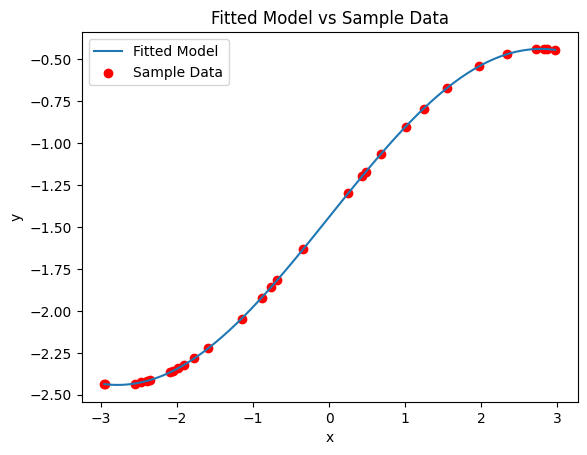

In [37]:
import math
import re
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# --- Utility: Uniquify Constant Tokens in the RPN Expression ---

def uniquify_rpn_constants(rpn_expr):
    """
    Replace each occurrence of "C" in the RPN expression with a unique constant name.
    For example:
      "C C x1 * C + sin * C +"
    becomes:
      "C_0 C_1 x1 * C_2 + sin * C_3 +"
    Returns the new expression and the total number of constants.
    """
    tokens = rpn_expr.split()
    new_tokens = []
    count = 0
    for token in tokens:
        if token == "C":
            new_tokens.append(f"C_{count}")
            count += 1
        else:
            new_tokens.append(token)
    new_expr = " ".join(new_tokens)
    return new_expr, count

# --- Tokenization and RPN Evaluation with Parameters ---

def tokenize(expression):
    token_pattern = r'\d+\.\d+|\d+|[A-Za-z_][A-Za-z0-9_]*|\*\*|[+\-*/()]'
    tokens = re.findall(token_pattern, expression)
    return tokens

def evaluate_rpn_with_params(rpn_expr, x_value, params):
    """
    Evaluate the RPN expression for a given x_value and a dictionary of constant parameters.
    - 'x1' is replaced with x_value.
    - Tokens matching the pattern 'C_<number>' are replaced with their corresponding value from params.
    - Recognized functions: sin, cos, exp, log.
    - Operators: +, -, *, /, **.
    """
    tokens = rpn_expr.split()
    stack = []
    for token in tokens:
        # Try interpreting token as a number.
        try:
            stack.append(float(token))
            continue
        except ValueError:
            pass
        
        # Substitute variable.
        if token == 'x1':
            stack.append(x_value)
        # Substitute unique constant (e.g., "C_0", "C_1", etc.)
        elif re.match(r'C_\d+', token):
            if token in params:
                stack.append(params[token])
            else:
                raise ValueError(f"Parameter {token} not found in params.")
        # Functions.
        elif token in {"sin", "cos", "exp", "log"}:
            a = stack.pop()
            if token == "sin":
                stack.append(math.sin(a))
            elif token == "cos":
                stack.append(math.cos(a))
            elif token == "exp":
                stack.append(math.exp(a))
            elif token == "log":
                if a <= 0:
                    raise ValueError("Logarithm argument must be positive.")
                stack.append(math.log(a))
        # Binary operators.
        elif token in {"+", "-", "*", "/", "**"}:
            b = stack.pop()
            a = stack.pop()
            if token == "+":
                stack.append(a + b)
            elif token == "-":
                stack.append(a - b)
            elif token == "*":
                stack.append(a * b)
            elif token == "/":
                stack.append(a / b)
            elif token == "**":
                stack.append(a ** b)
        else:
            raise ValueError("Unknown token: " + token)
    if len(stack) != 1:
        raise ValueError("RPN evaluation did not result in a single output.")
    return stack[0]

def extract_constant_names(rpn_expr):
    """
    Extracts the list of unique constant names (e.g., ["C_0", "C_1", ...])
    from the RPN expression. Since our uniquify function gives each "C" a unique name,
    the constants appear in order.
    """
    tokens = rpn_expr.split()
    constants = [token for token in tokens if re.match(r'C_\d+', token)]
    return constants

def model_predictions(rpn_expr, x_data, params):
    """
    Evaluate the RPN model on an array of x_data given a dictionary of parameters.
    Returns a numpy array of predictions.
    """
    preds = []
    for x in x_data:
        try:
            preds.append(evaluate_rpn_with_params(rpn_expr, x, params))
        except Exception:
            preds.append(np.nan)
    return np.array(preds)

# --- Constant Fitting Function ---

def fit_constants(original_rpn_expr, X_data, Y_data):
    """
    Fits the distinct constants in the RPN expression (each "C" is independent)
    so that the model predictions best match Y_data.
    Uses SciPy's L-BFGS-B optimization (minimizing sum of squared errors) with bounds.
    
    Returns:
      - The new RPN expression with unique constant names.
      - A dictionary mapping each unique constant (e.g., "C_0", "C_1", ...) to its fitted value.
    """
    # Convert the original RPN expression to one with unique constants.
    unique_rpn_expr, n_constants = uniquify_rpn_constants(original_rpn_expr)
    constant_names = extract_constant_names(unique_rpn_expr)
    
    # Initial guess for each constant: 1.0
    initial_guess = np.ones(len(constant_names))
    
    # Bounds for each constant: [-2.1, 2.1]
    bounds = [(-2.1, 2.1)] * len(constant_names)
    
    def objective(param_vector):
        params = {name: value for name, value in zip(constant_names, param_vector)}
        predictions = model_predictions(unique_rpn_expr, X_data, params)
        # Return a large penalty if any prediction failed.
        if np.isnan(predictions).any():
            return 1e10
        error = np.sum((predictions - Y_data)**2)
        return error
    
    # Minimize using L-BFGS-B with bounds.
    result = minimize(objective, initial_guess, method='L-BFGS-B', bounds=bounds)
    fitted_params = {name: value for name, value in zip(constant_names, result.x)}
    return unique_rpn_expr, fitted_params

# --- Process and Plot Function ---

def process_and_plot(record):
    """
    Processes a single record by:
      - Extracting "X" and "Y" sample data.
      - Creating an evenly spaced array of 100 points between min(X) and max(X).
      - Fitting the constants in the RPN equation (where each "C" is unique) using L-BFGS-B regression with bounds.
      - Evaluating the fitted model on the 100 points.
      - Plotting the fitted function (line) and the sample ("X", "Y") data (points).
    """
    # Extract sample data.
    X_sample = np.array(record["X"])
    Y_sample = np.array(record["Y"])
    
    # Create an evaluation grid.
    x_min, x_max = X_sample.min(), X_sample.max()
    x_eval = np.linspace(x_min, x_max, 100)
    
    # Get the original RPN expression (with repeated "C" tokens).
    original_rpn_expr = record["RPN"]
    
    # Fit the constants (each "C" is treated as a separate parameter).
    unique_rpn_expr, fitted_params = fit_constants(original_rpn_expr, X_sample, Y_sample)
    print("Fitted Parameters:", fitted_params)
    
    # Evaluate the fitted model on the evaluation grid.
    y_eval = []
    for x in x_eval:
        try:
            y_eval.append(evaluate_rpn_with_params(unique_rpn_expr, x, fitted_params))
        except Exception:
            y_eval.append(np.nan)
    y_eval = np.array(y_eval)
    
    # Plot the fitted function and sample points.
    plt.figure()
    plt.plot(x_eval, y_eval, label="Fitted Model")
    plt.scatter(X_sample, Y_sample, color="red", label="Sample Data")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.title("Fitted Model vs Sample Data")
    plt.show()

# --- Example Usage ---
# Assume 'data' is a list of records loaded from your JSON file,
# and that each record has keys "X", "Y", and "RPN".
# For example, to process and plot the record with index 104:
process_and_plot(data[104])